In [ ]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
from skimage import io
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
!unzip -q 'Group_6.zip'

Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model

Comparison

In [ ]:
pip install matplotlib

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import os

# **Model Arch**

In [ ]:
import os
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Group_6/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2150 files belonging to 5 classes.


In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Group_6/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 250 files belonging to 5 classes.


In [ ]:
class_names= train_dataset.class_names if train_dataset.class_names==test_dataset.class_names else 'Classes don\'t match among train,test, and validation dataset'
class_names

['remote', 'rocker', 'schoolbus', 'scoreboard', 'sombrero']

In [ ]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 3 3 1 0 1 2 4 4 3 3 2 3 2 2 2 0 1 1 2 3 4 1 2 1 4 0 3 3 2 1 3]


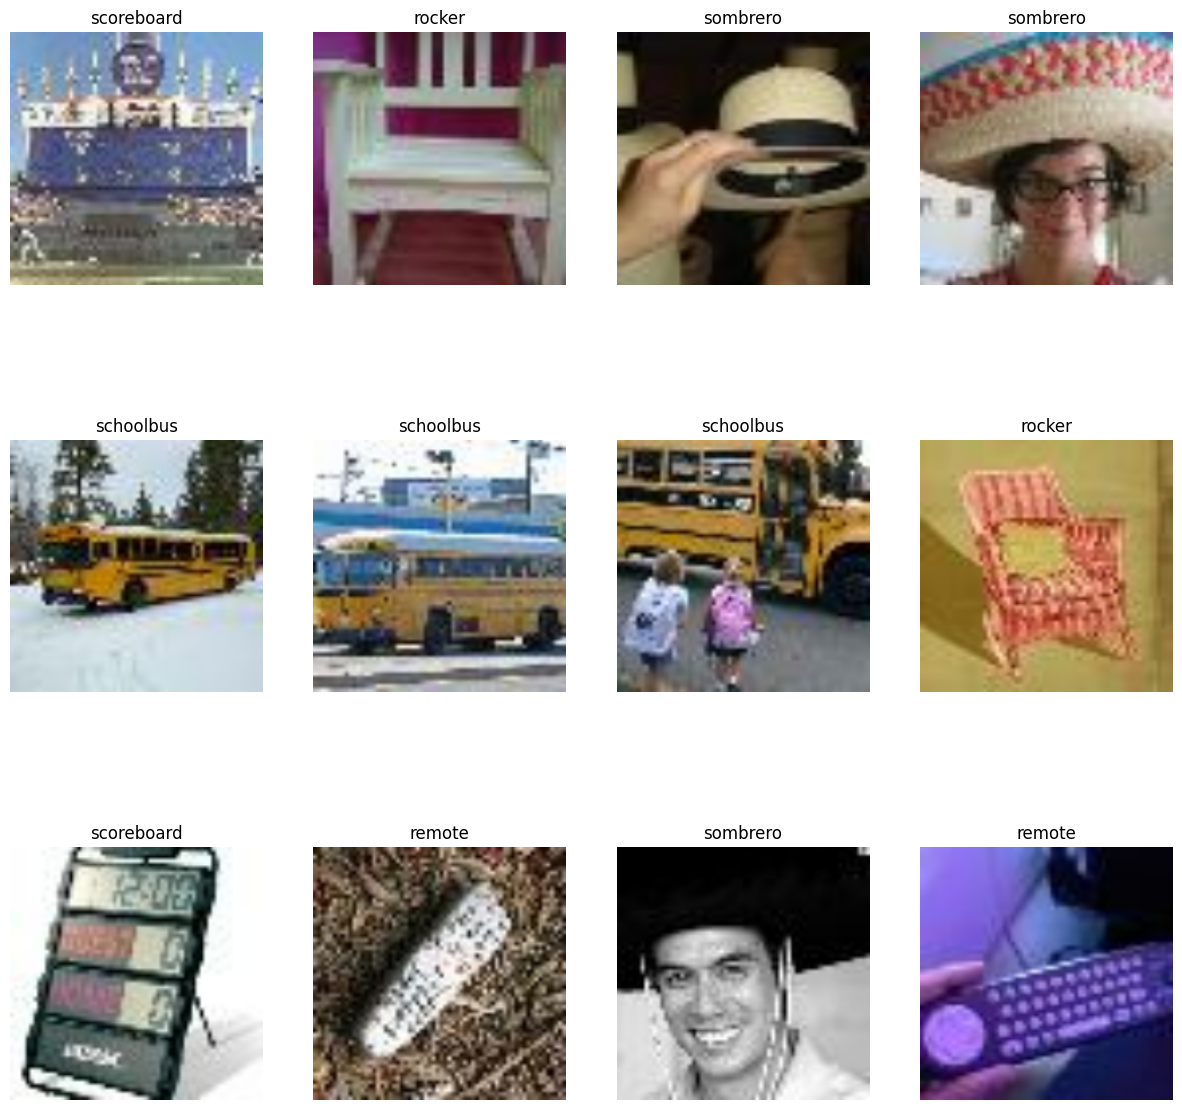

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split  + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    # val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    # val_ds = ds.skip(train_size).take(val_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_dataset)

(54, 14, 8)

# *Cacha, Shuffle, prefetch*

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


## Apply data aug to training data

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
save_dir = '/content/Model1'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

## RESNET FROM SCRATCH___

In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model,load_model
import itertools

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the Residual Block
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut connection if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define the ResNet model
def build_resnet(input_shape, num_classes, num_blocks, num_filters):
    input_layer = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=(5, 5), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Building the residual blocks
    for i in range(3):
        stride = 1 if i == 0 else 2  # First block uses stride 1, the rest use stride 2
        x = residual_block(x, filters=num_filters, stride=stride)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

input_shape = (224, 224, 3)
num_classes = 5

num_blocks = 3
num_filters = 64

resnet_model = build_resnet(input_shape, num_classes, num_blocks, num_filters)

resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 112, 112, 64)         4864      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 112, 112, 64)         256       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_14 (ReLU)             (None, 112, 112, 64)         0         ['batch_normalization_18

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=4,
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/4
54/54 [==============================] - 19s 232ms/step - loss: 1.2692 - accuracy: 0.4983 - val_loss: 4.5550 - val_accuracy: 0.3013
Epoch 2/4
54/54 [==============================] - 12s 223ms/step - loss: 1.1343 - accuracy: 0.5498 - val_loss: 2.0255 - val_accuracy: 0.4688
Epoch 3/4
54/54 [==============================] - 12s 228ms/step - loss: 1.0781 - accuracy: 0.5851 - val_loss: 2.9853 - val_accuracy: 0.4085
Epoch 4/4
54/54 [==============================] - 12s 221ms/step - loss: 1.0513 - accuracy: 0.5990 - val_loss: 1.7637 - val_accuracy: 0.4286


In [ ]:
new_model2=tf.keras.models.load_model("/content/Model1/checkpoint-38-0.77.h5")

In [ ]:
# scores = history.evaluate(test_ds)
test_loss, test_accuracy = resnet_model.evaluate(test_ds)

8/8 [==============================] - 1s 22ms/step - loss: 1.6112 - accuracy: 0.4040


8/8 [==============================] - 0s 23ms/step


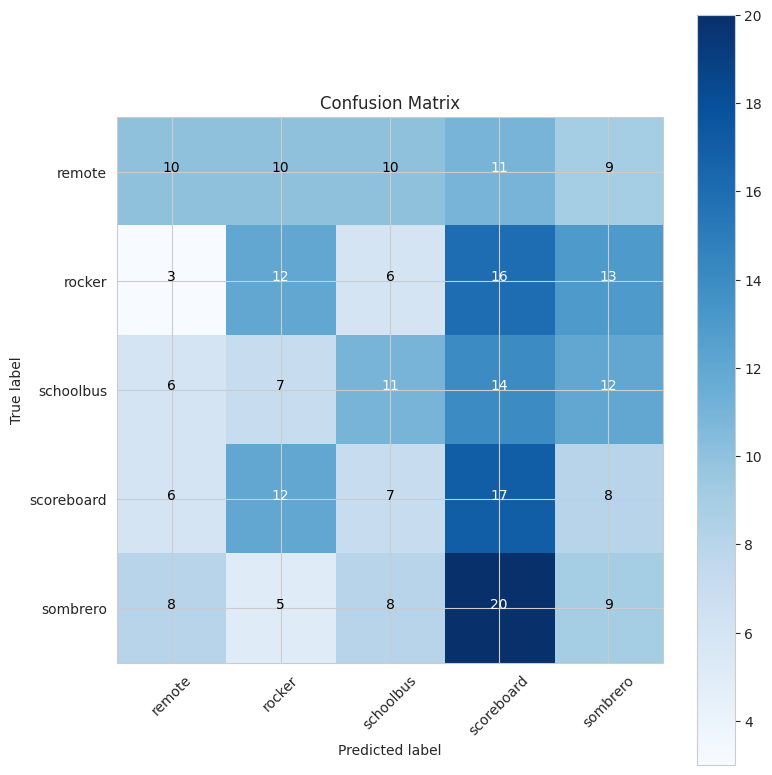

In [ ]:
predictions0 = new_model2.predict(test_ds)
predicted_labels0 = np.argmax(predictions0, axis=1)
true_labels0 = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx0 = confusion_matrix(true_labels0, predicted_labels0)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['remote', 'rocker', 'schoolbus', 'scoreboard', 'sombrero']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx0, class_names)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_labels0, predicted_labels0, target_names=['remote', 'rocker', 'schoolbus', 'scoreboard', 'sombrero'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

      remote       0.30      0.20      0.24        50
      rocker       0.26      0.24      0.25        50
   schoolbus       0.26      0.22      0.24        50
  scoreboard       0.22      0.34      0.27        50
    sombrero       0.18      0.18      0.18        50

    accuracy                           0.24       250
   macro avg       0.24      0.24      0.23       250
weighted avg       0.24      0.24      0.23       250



In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx0.shape[0]):
    tp = confusion_mtx0[class_label, class_label]
    fn = np.sum(confusion_mtx0[class_label, :]) - tp
    fp = np.sum(confusion_mtx0[:, class_label]) - tp
    tn = np.sum(confusion_mtx0) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx0.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.236
Specificity (Average): 0.8089999999999999
PPV (Positive Predictive Value) (Average): 0.24404478726729367
NPV (Negative Predictive Value) (Average): 0.8088006154182015


# --------------------------------------------------------------------------------------

In [ ]:
show={}
show['Resnet50'] = scores[1]

In [ ]:
history.history.keys()
history.history

{'loss': [1.269201636314392,
  1.1343473196029663,
  1.0781397819519043,
  1.0513043403625488],
 'accuracy': [0.4982638955116272,
  0.5497685074806213,
  0.5850694179534912,
  0.5989583134651184],
 'val_loss': [4.55495023727417,
  2.0255417823791504,
  2.9852519035339355,
  1.7637349367141724],
 'val_accuracy': [0.3013392984867096,
  0.46875,
  0.4084821343421936,
  0.4285714328289032]}

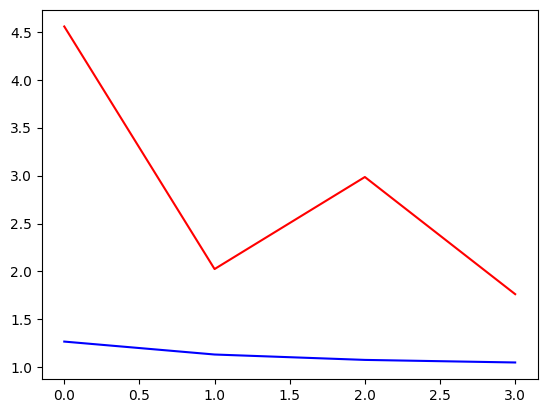

In [ ]:
plt.plot(range(4), history.history["loss"][:4], 'b')
plt.plot(range(4), history.history["val_loss"][:4], 'r')
plt.show()

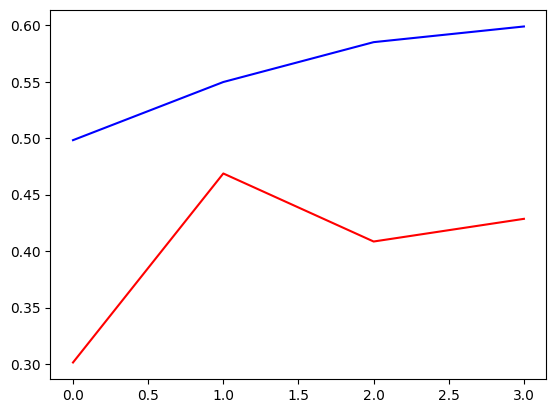

In [ ]:
plt.plot(range(4), history.history["accuracy"][:4], 'b')
plt.plot(range(4), history.history["val_accuracy"][:4], 'r')
plt.show()

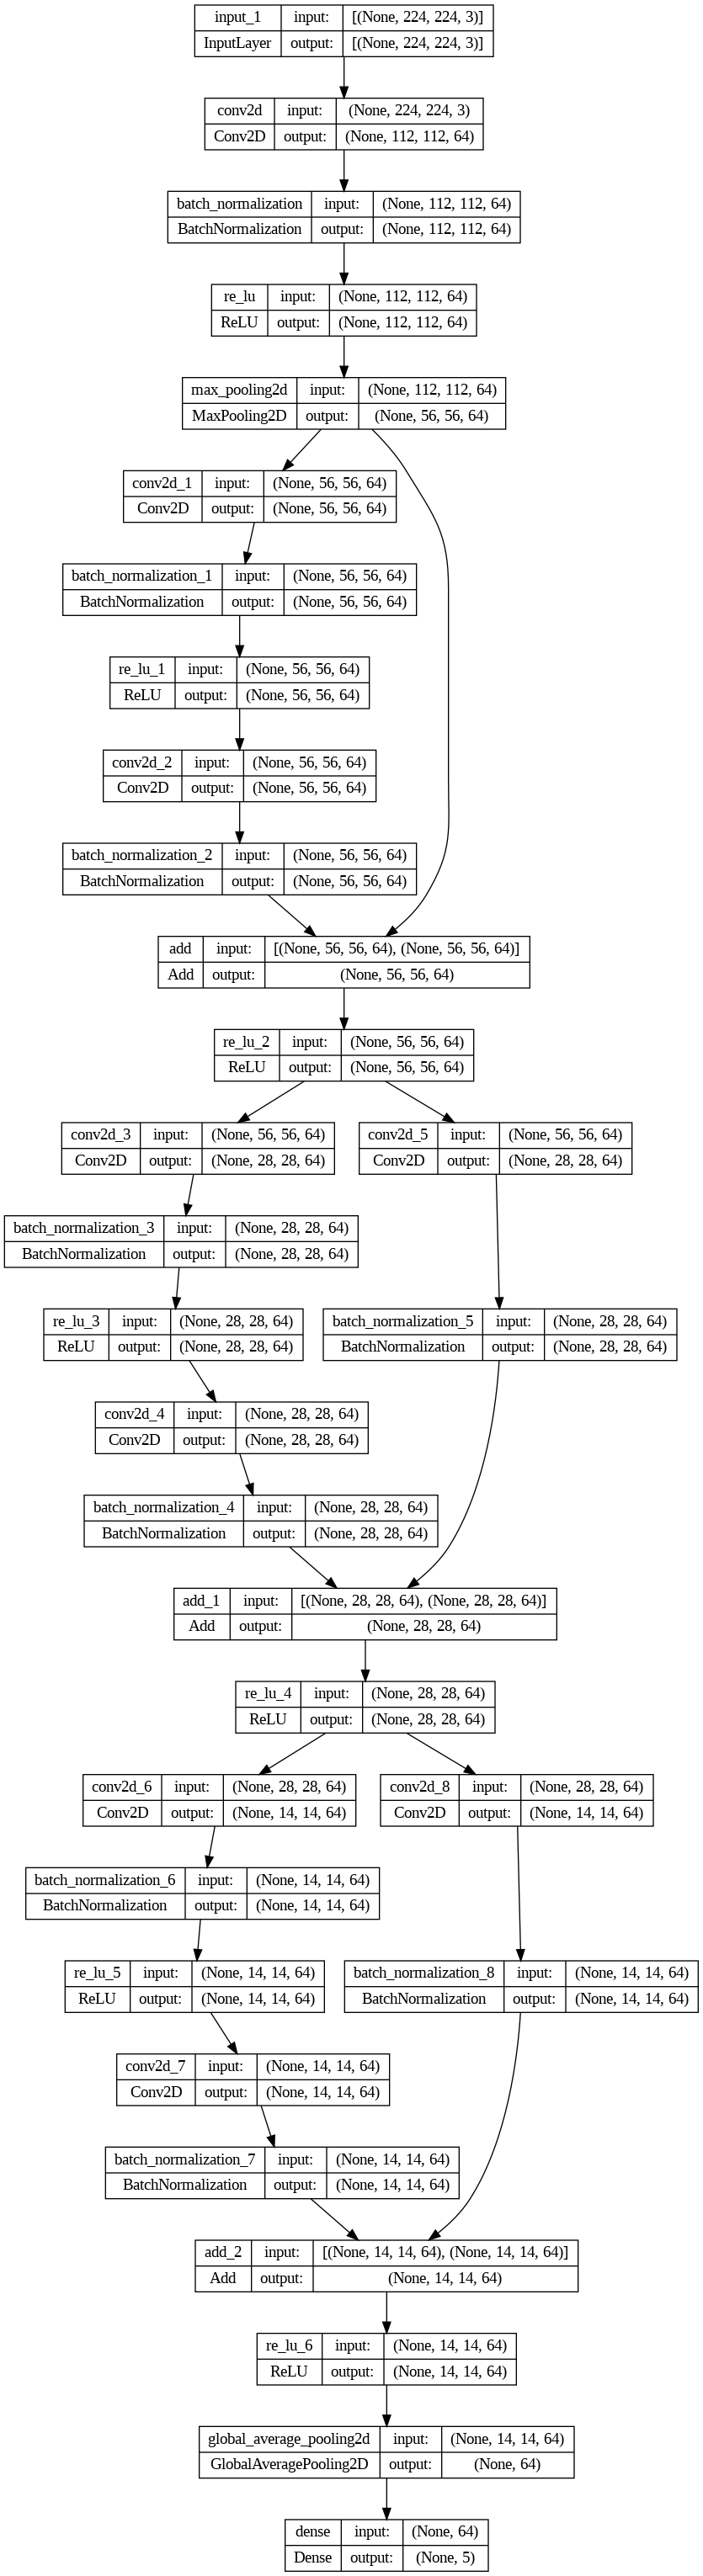

In [ ]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

## InceptionNet!

In [ ]:
save_dir = '/content/Model2'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Define a custom Inception-like block
def inception_block(x, filters):
    # 1x1 Convolution
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 Convolution followed by 5x5 Convolution
    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 Max Pooling followed by 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all branches
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])
    return output

# Define the custom InceptionNet model
def build_inception_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build the custom inception-like blocks
    x = inception_block(x, [64, 128, 128, 32, 32, 32])
    x = inception_block(x, [128, 192, 192, 96, 96, 64])

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build the custom InceptionNet model
inception_model = build_inception_net(input_shape, num_classes)

# Display model summary
inception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_11 (Conv2D)          (None, 56, 56, 128)          8320      ['max_pooling2d_1[0][0]'

In [ ]:
inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history2 =inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/40
54/54 [==============================] - 43s 638ms/step - loss: 372.8976 - accuracy: 0.2922 - val_loss: 1.5036 - val_accuracy: 0.3460
Epoch 2/40
54/54 [==============================] - 31s 576ms/step - loss: 1.4239 - accuracy: 0.4022 - val_loss: 1.3246 - val_accuracy: 0.4531
Epoch 3/40
54/54 [==============================] - 33s 616ms/step - loss: 1.3136 - accuracy: 0.4653 - val_loss: 1.2887 - val_accuracy: 0.4777
Epoch 4/40
54/54 [==============================] - 34s 630ms/step - loss: 1.2929 - accuracy: 0.4786 - val_loss: 1.2201 - val_accuracy: 0.4866
Epoch 5/40
54/54 [==============================] - 36s 681ms/step - loss: 1.2148 - accuracy: 0.4977 - val_loss: 1.1803 - val_accuracy: 0.5379
Epoch 6/40
54/54 [==============================] - 16s 286ms/step - loss: 1.1832 - accuracy: 0.5278 - val_loss: 1.2211 - val_accuracy: 0.5089
Epoch 7/40
54/54 [==============================] - 15s 282ms/step - loss: 1.1644 - accuracy: 0.5394 - val_loss: 1.1562 - val_accuracy: 0.53

In [ ]:
new_model3=tf.keras.models.load_model("/content/Model2/checkpoint-38-0.76.h5")

In [ ]:
scores2 = new_model3.evaluate(test_ds)

8/8 [==============================] - 1s 54ms/step - loss: 1.0026 - accuracy: 0.6000


#
#aggregate metrics for InceptionNet

In [ ]:
predictions = new_model3.predict(test_ds)

8/8 [==============================] - 1s 53ms/step


In [ ]:
predicted_labels2 = np.argmax(predictions, axis=1)

In [ ]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
confusion_mtx = confusion_matrix(true_labels, predicted_labels2)

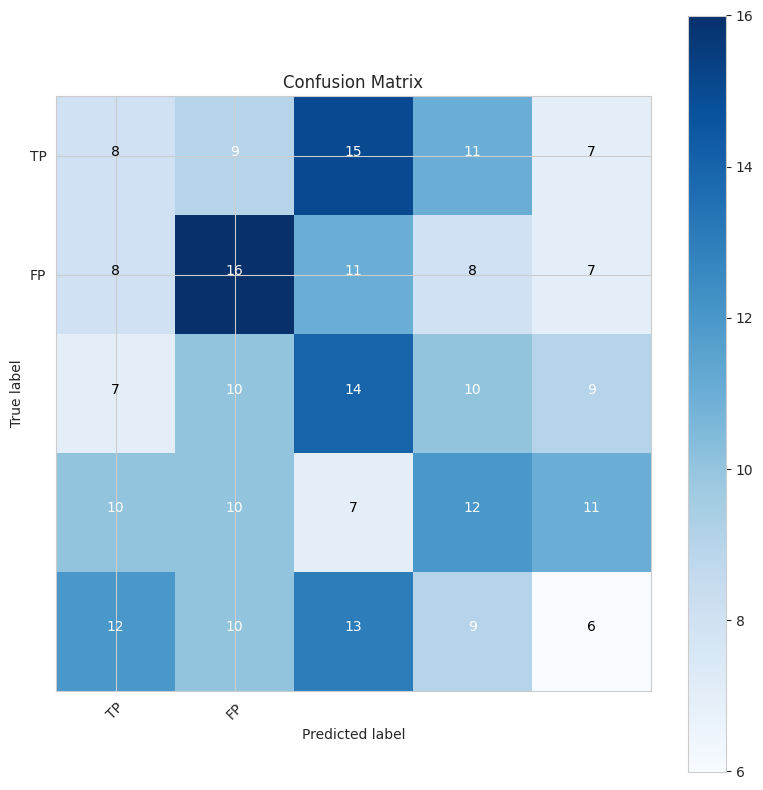

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['TP', 'FP']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, class_names)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_labels, predicted_labels2, target_names=["Class 0", "Class 1", "Class 2","Class 3","Class 4"])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

     Class 0       0.18      0.16      0.17        50
     Class 1       0.29      0.32      0.30        50
     Class 2       0.23      0.28      0.25        50
     Class 3       0.24      0.24      0.24        50
     Class 4       0.15      0.12      0.13        50

    accuracy                           0.22       250
   macro avg       0.22      0.22      0.22       250
weighted avg       0.22      0.22      0.22       250



In [ ]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx.shape[0]):
    tp = confusion_mtx[class_label, class_label]
    fn = np.sum(confusion_mtx[class_label, :]) - tp
    fp = np.sum(confusion_mtx[:, class_label]) - tp
    tn = np.sum(confusion_mtx) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.22400000000000003
Specificity (Average): 0.806
PPV (Positive Predictive Value) (Average): 0.21840404040404038
NPV (Negative Predictive Value) (Average): 0.8063530966252405


# ------------------------------------------------------------------------------------------------------

In [ ]:
show['InceptionNet'] = scores2[1]

In [ ]:
# history2.history.keys()
history2.history

{'loss': [372.89764404296875,
  1.42389976978302,
  1.3136413097381592,
  1.2928506135940552,
  1.2148486375808716,
  1.1831623315811157,
  1.164385437965393,
  1.1335158348083496,
  1.1207454204559326,
  1.080759882926941,
  1.0800076723098755,
  1.0406678915023804,
  1.0226305723190308,
  1.053635597229004,
  1.0228036642074585,
  0.9760827422142029,
  0.9926558136940002,
  0.964870810508728,
  1.0092138051986694,
  1.0063581466674805,
  0.9443023800849915,
  0.9654056429862976,
  0.9580894708633423,
  0.9487019181251526,
  0.9016343355178833,
  0.8899852633476257,
  0.8734592795372009,
  0.8733123540878296,
  0.8466853499412537,
  0.8625063896179199,
  0.8650059700012207,
  0.8441910743713379,
  0.8102694749832153,
  0.8611466884613037,
  0.8317904472351074,
  0.8251562714576721,
  0.8321352601051331,
  0.8052946925163269,
  0.8047913908958435,
  0.8340746760368347],
 'accuracy': [0.29224535822868347,
  0.40219905972480774,
  0.4652777910232544,
  0.47858795523643494,
  0.4976851940

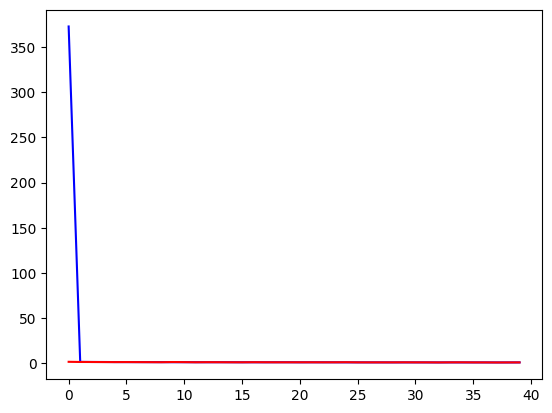

In [ ]:
plt.plot(range(40), history2.history["loss"][:40], 'b')
plt.plot(range(40), history2.history["val_loss"][:40], 'r')
plt.show()

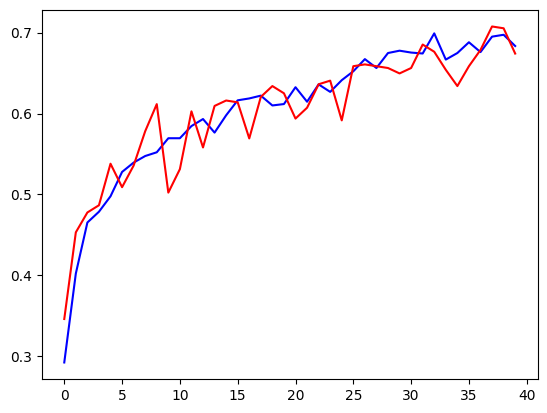

In [ ]:
plt.plot(range(40), history2.history["accuracy"][:40], 'b')
plt.plot(range(40), history2.history["val_accuracy"][:40], 'r')
plt.show()

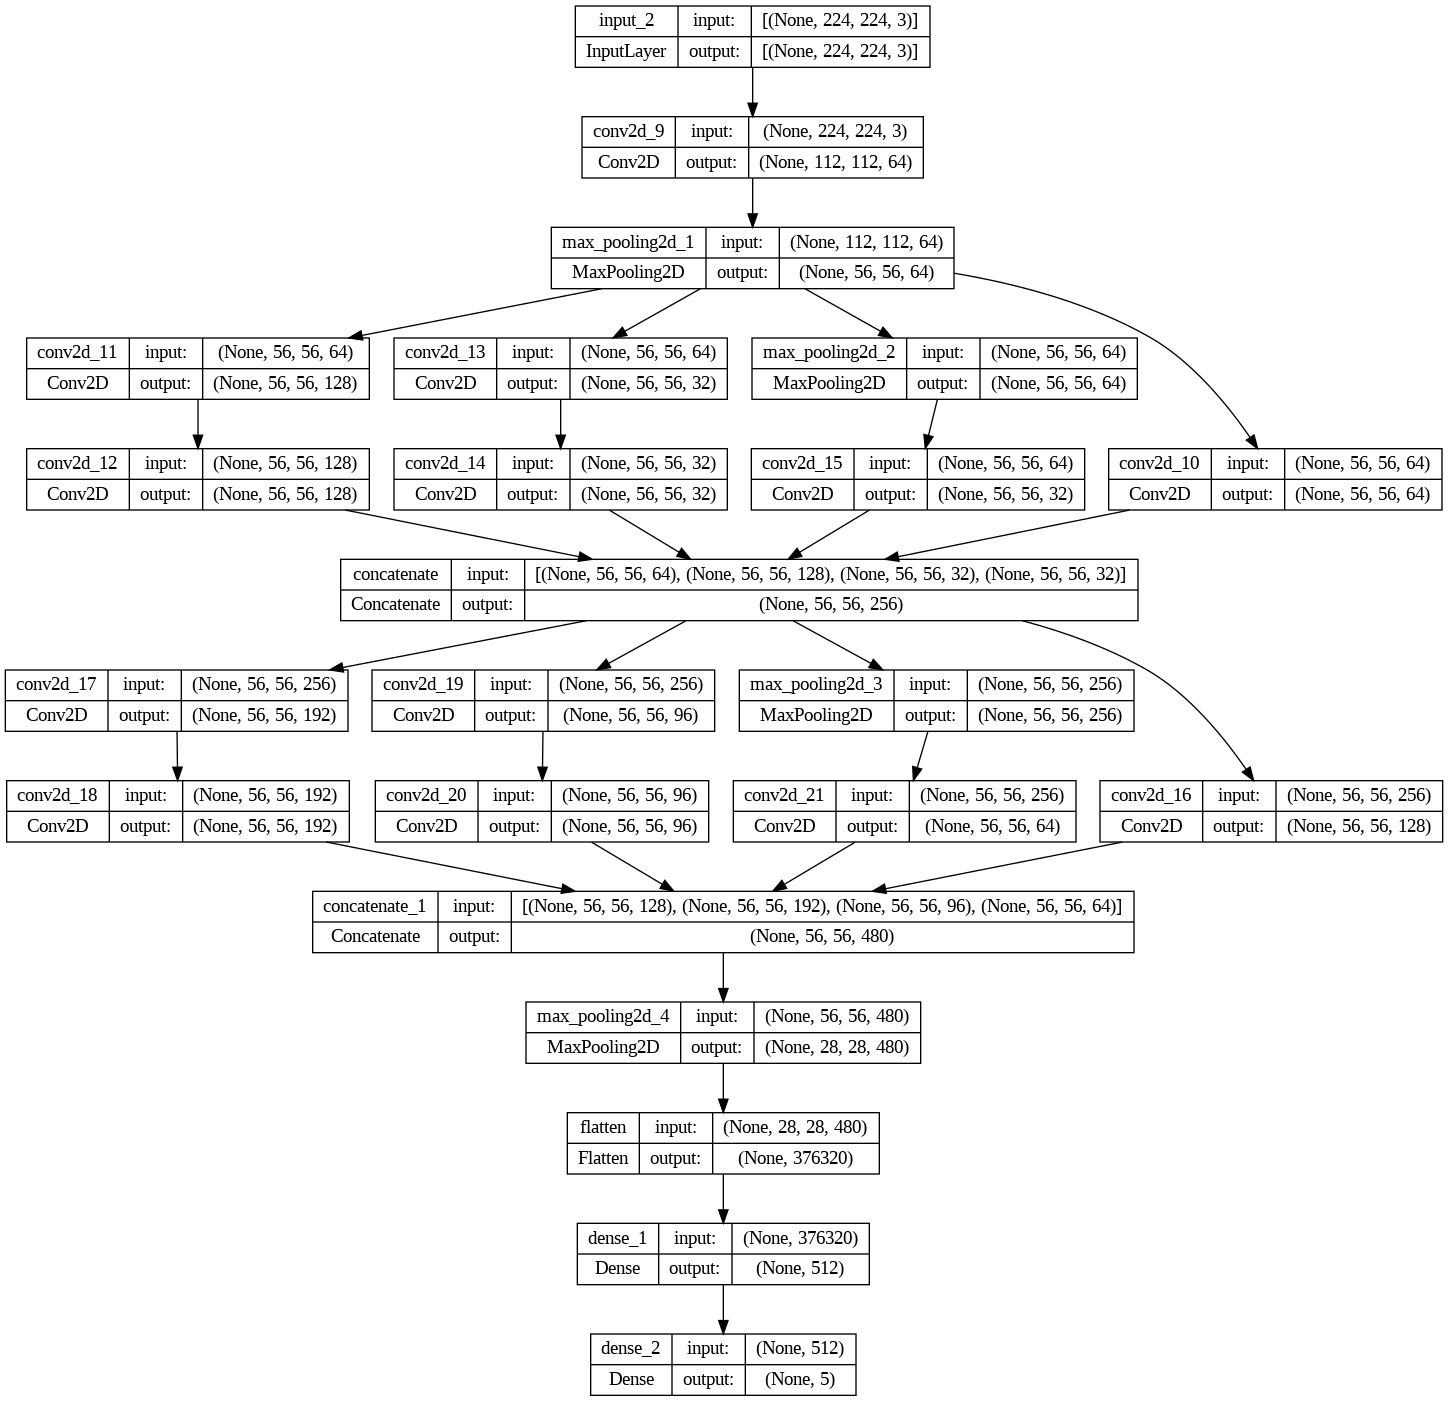

In [ ]:
tf.keras.utils.plot_model(inception_model, show_shapes=True)

# Custom Model

In [ ]:
save_dir = '/content/Model3'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Define a custom Inception-like block with more flexibility
def custom_inception_block(x, filters):
    branch_1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch_3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch_3x3)

    branch_5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch_5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return output

# Define a custom InceptionNet model with additional customization
def build_custom_inception_net(input_shape, num_classes, num_blocks=2, num_filters_per_block=None):
    if num_filters_per_block is None:
        num_filters_per_block = [[64, 128, 128, 32, 32, 32]] * num_blocks

    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build custom Inception-like blocks
    for filters in num_filters_per_block:
        x = custom_inception_block(x, filters)

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Customize the architecture by specifying num_blocks and num_filters_per_block
custom_inception_model = build_custom_inception_net(
    input_shape, num_classes, num_blocks=3, num_filters_per_block=[
        [64, 128, 128, 32, 32, 32],
        [128, 192, 192, 64, 64, 64],
        [192, 256, 256, 96, 96, 96]
    ])

# Display model summary
custom_inception_model.summary()

In [ ]:
custom_inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history2 =custom_inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/40
54/54 [==============================] - 29s 321ms/step - loss: 357.5638 - accuracy: 0.2425 - val_loss: 1.5490 - val_accuracy: 0.2969
Epoch 2/40
54/54 [==============================] - 18s 322ms/step - loss: 1.5444 - accuracy: 0.3171 - val_loss: 1.5865 - val_accuracy: 0.2812
Epoch 3/40
54/54 [==============================] - 18s 332ms/step - loss: 1.3864 - accuracy: 0.4167 - val_loss: 1.3552 - val_accuracy: 0.4152
Epoch 4/40
54/54 [==============================] - 19s 346ms/step - loss: 1.2574 - accuracy: 0.4769 - val_loss: 1.3052 - val_accuracy: 0.4442
Epoch 5/40
54/54 [==============================] - 17s 321ms/step - loss: 1.2275 - accuracy: 0.5041 - val_loss: 1.1908 - val_accuracy: 0.5246
Epoch 6/40
54/54 [==============================] - 18s 334ms/step - loss: 1.1936 - accuracy: 0.5156 - val_loss: 1.1381 - val_accuracy: 0.5357
Epoch 7/40
54/54 [==============================] - 17s 313ms/step - loss: 1.1816 - accuracy: 0.5260 - val_loss: 1.1563 - val_accuracy: 0.48

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 129s 2s/step - loss: 0.8244 - accuracy: 0.6881 - val_loss: 0.7502 - val_accuracy: 0.7388
Epoch 35/40
54/54 [==============================] - 17s 318ms/step - loss: 0.8153 - accuracy: 0.7020 - val_loss: 0.8048 - val_accuracy: 0.7232
Epoch 36/40
54/54 [==============================] - 18s 322ms/step - loss: 0.8232 - accuracy: 0.6939 - val_loss: 0.8907 - val_accuracy: 0.6629
Epoch 37/40
54/54 [==============================] - 19s 340ms/step - loss: 0.8350 - accuracy: 0.6759 - val_loss: 0.7748 - val_accuracy: 0.6964
Epoch 38/40
54/54 [==============================] - 18s 323ms/step - loss: 0.9048 - accuracy: 0.6661 - val_loss: 0.9344 - val_accuracy: 0.6562
Epoch 39/40
54/54 [==============================] - 19s 341ms/step - loss: 1.0264 - accuracy: 0.6366 - val_loss: 2.0161 - val_accuracy: 0.3929
Epoch 40/40
54/54 [==============================] - 18s 328ms/step - loss: 1.4182 - accuracy: 0.3970 - val_loss: 1.2800 - val_accuracy: 0.4576


In [ ]:
new_model4=tf.keras.models.load_model("/content/checkpoint-34-0.79.h5")

In [ ]:
scores = new_model4.evaluate(test_ds)

8/8 [==============================] - 1s 28ms/step - loss: 1.1375 - accuracy: 0.6200


In [ ]:
show['Custom Model'] = scores[1]

-
-
-
-
-
## Predicting image labels by using resnet I have used earlier (RESNET50)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


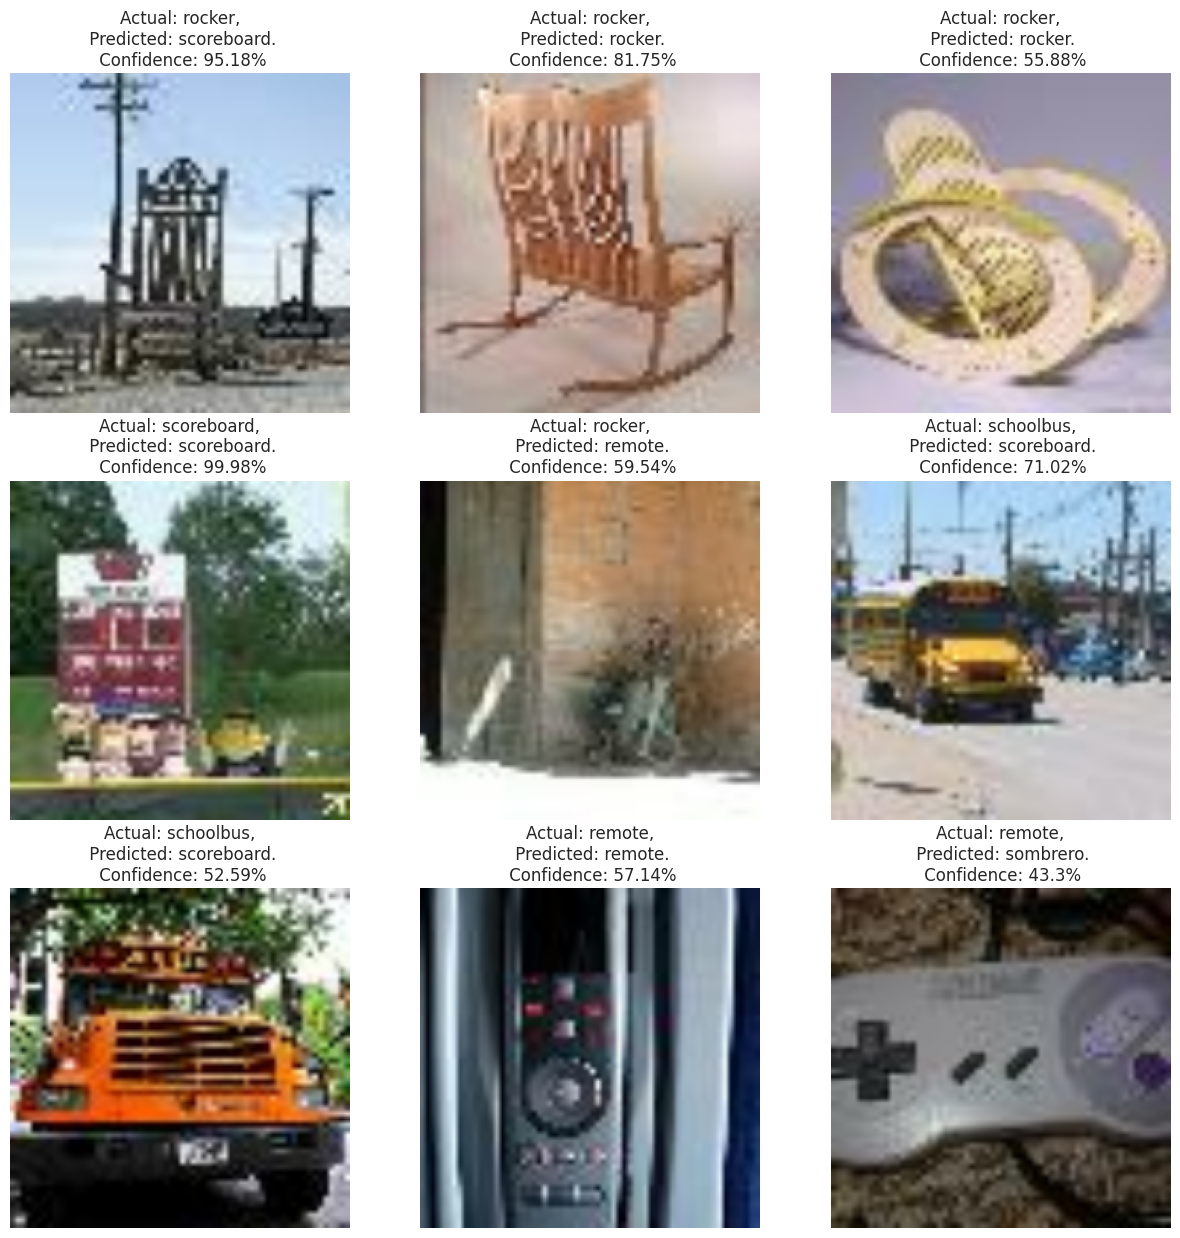

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model2, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Predicting image labels by using resnet I have used earlier (InceptionNet)

1/1 [==============================] - 0s 21ms/step


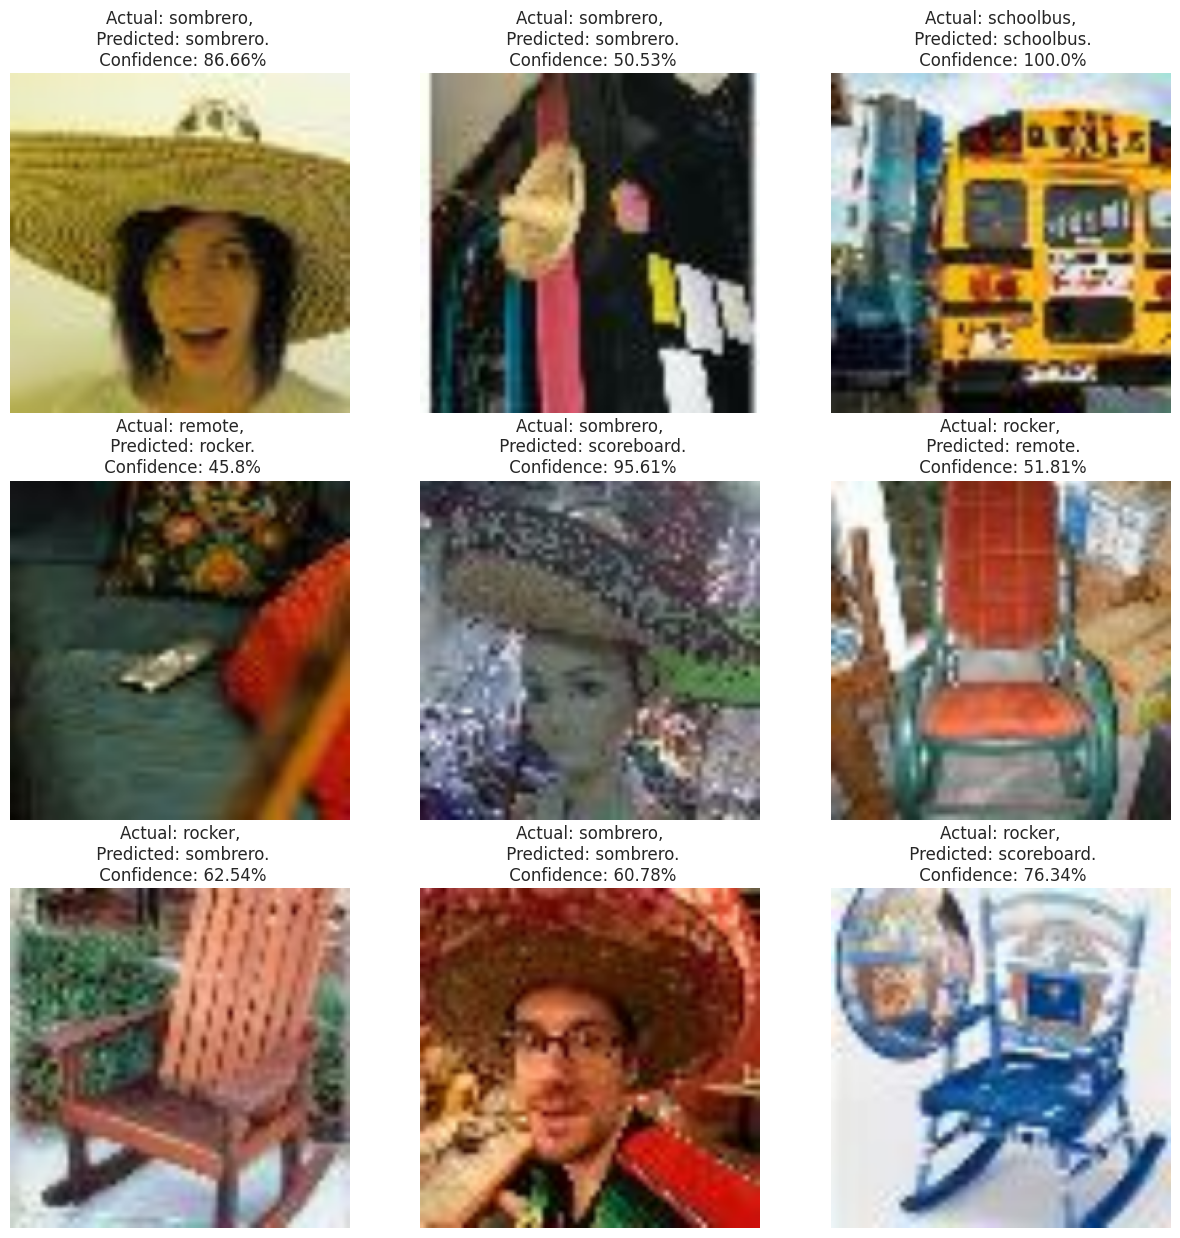

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(new_model3, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

--
--
# COMparison GRAphs

<Figure size 1500x1500 with 0 Axes>

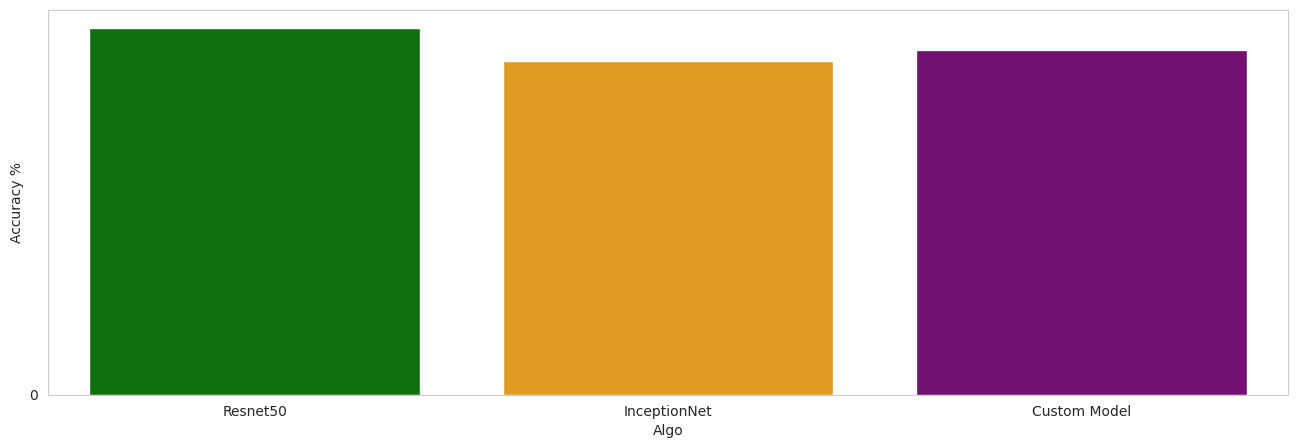

<Figure size 1500x1500 with 0 Axes>

In [ ]:
import seaborn as sns
colors = ["green","orange","purple"]
sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algo")
sns.barplot(x=list(show.keys()), y=list(show.values()), palette=colors)
plt.figure(figsize=(15, 15))